In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constrained optimization: equality and inequality constraints

Flàvia Ferrús and David Rosado

First of all, let us import some functions related to the implementation of KKT in order to minimize the following:
\begin{cases}
\text{min}\hspace{0.2cm} f(x)=\frac{1}{2}x^TGx + g^Tx\\
\text{subject to}\hspace{0.2cm}A^Tx=b, C^Tx\geq d
\end{cases}
where $G$  is symmetric semidefinite positive. The functions are given by the teacher in the Virtual Campus.

In [2]:
from QPGC import QPGenericConstraints

## Necessary functions

Let us implement some necessary functions before starting with the proposed experiments. Concretely, the creation of the dataset, the creation of the needed matrices and finally a function that computes the required hyperplane.

In [10]:
#Creation of the dataset
def dataset(n_points, separable = True):
    m1 = np.array([0., 0.])
    s1 = np.array([[1., -0.9], [-0.9, 1.]])
    if separable:
        m2 = np.array([3., 6.])
        s2 = np.array([[1., 0.], [0., 1.]])
    else:
        m2 = np.array([1., 2.])
        s2 = np.array([[1., 0.], [0., 1.]])

    pos_class = np.random.multivariate_normal(m1, s1, n_points)
    neg_class = np.random.multivariate_normal(m2, s2, n_points)
    x = np.concatenate((pos_class, neg_class)).T
    y = np.concatenate((np.ones(n_points), -1*np.ones(n_points)))

    return x,y

#Generation of the matrices (see equation (8) of the project)
#Observe that maximize f is equivalent to minimize -f
def generation_matrices(x,y,K):
    #Dimensions
    n = x.shape[1] #number of points
    m = 2*n
    p = 1
    #Matrices construction
    G = np.dot(np.dot(np.diag(y), x.T), np.dot(x, np.diag(y)))
    g = -np.ones(n)
    A = y.reshape(n, p)
    b = np.zeros(p) 
    C = np.concatenate((np.eye(n), -np.eye(n)), axis = 1)
    d = np.concatenate((np.zeros(n), -K*np.ones(n)))
    return G, g, A, b, C, d

#Compute the hyperplane
def hyper(x,y,alpha,K):
    #Let us compute w first
    w = np.sum(alpha * y * x, axis=1)
    b = []
    for i in range(0,alpha.shape[0]):
      if alpha[i]>0 and alpha[i]<K:
        b.append(y[i]-np.dot(w.T,x[:,i]))
    return w,np.median(b)

## Experiment 1

Let us start with the simplest case, i.e. the case in which data is separable,
and with a small dataset (2 points for each class, for instance). Let us also set $K=1$. We have to plot the hyperplane $f(x) = w^T x + b = 0$, as
well as the hyperplane at distance −1 and 1 respectively.

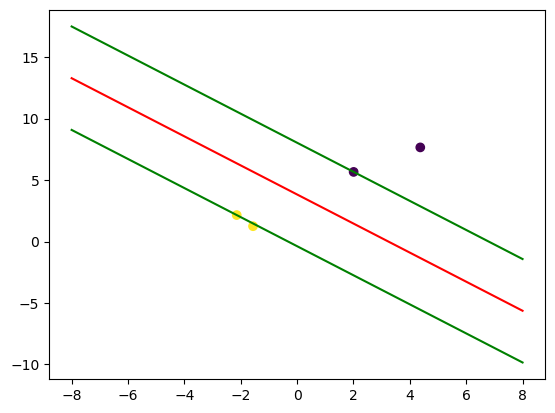

In [11]:
K=1
#Let us generate the dataset and the corresponding matrices
X, y = dataset(2)
G, g, A, b, C, d = generation_matrices(X, y, K)
#Let us compute alpha with the given code
alpha = QPGenericConstraints(G, g, A, C, b, d)
#Compute the hyperplane
w, b =hyper(X, y,alpha,K)
#Let us plot the result
x = np.linspace(-8, 8, 100)

plt.scatter(X[0,:], X[1,:],c=y)
plt.plot(x, -(w[0]*x + b+1) / w[1], 'g')
plt.plot(x, -(w[0]*x + b) / w[1], 'r')
plt.plot(x, -(w[0]*x + b-1) / w[1], 'g')
plt.show()

Notice that we have separate correctly the set of points. Moreover, the hyperplanes at distance −1 and 1  touch one(or more) points respectively, which are known as **support vectors**.

## Experiment 2

Let us increase the dataset, now with 100 samples for each class and see its performance.

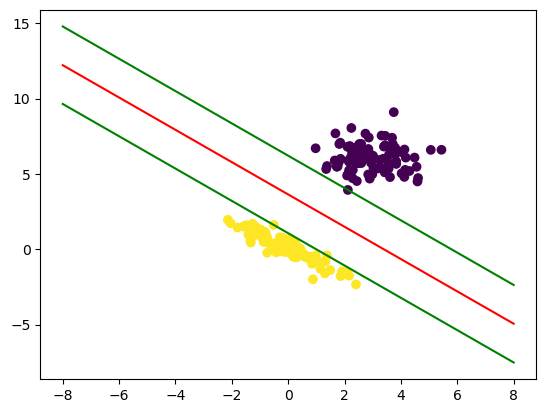

In [14]:
K=1
#Let us generate the dataset and the corresponding matrices
X, y = dataset(100)
G, g, A, b, C, d = generation_matrices(X, y, K)
#Let us compute alpha with the given code
alpha = QPGenericConstraints(G, g, A, C, b, d)
#Compute the hyperplane
w, b =hyper(X, y,alpha,K)
#Let us plot the result
x = np.linspace(-8, 8, 100)

plt.scatter(X[0,:], X[1,:],c=y)
plt.plot(x, -(w[0]*x + b+1) / w[1], 'g')
plt.plot(x, -(w[0]*x + b) / w[1], 'r')
plt.plot(x, -(w[0]*x + b-1) / w[1], 'g')
plt.show()

Notice that it works for "large" dataset!! The classification is perfect.

## Experiment 3

Let us perform several experiments with different values of $K$ and test the stability of the obtained solution. Does the value of K influence the obtained solution? That is, does the hyperplane separate correctly the set of points?

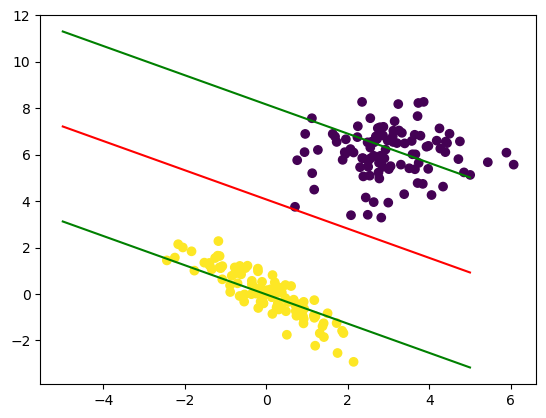

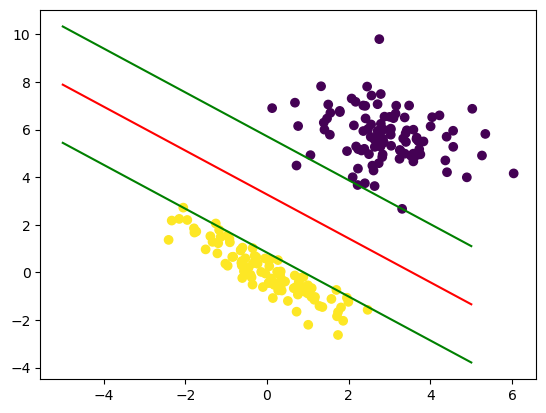

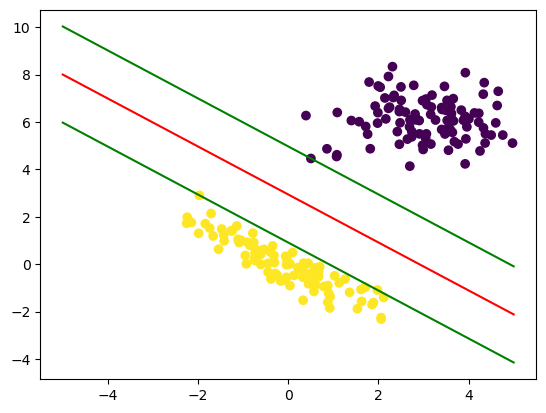

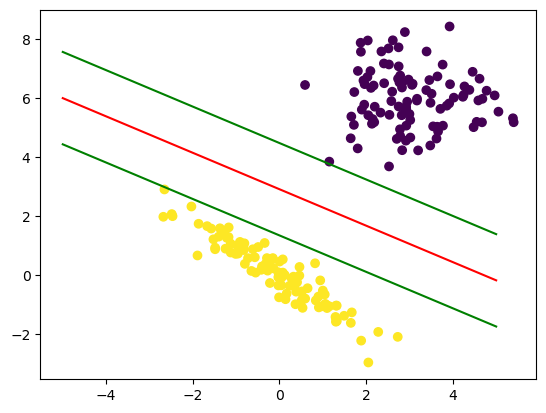

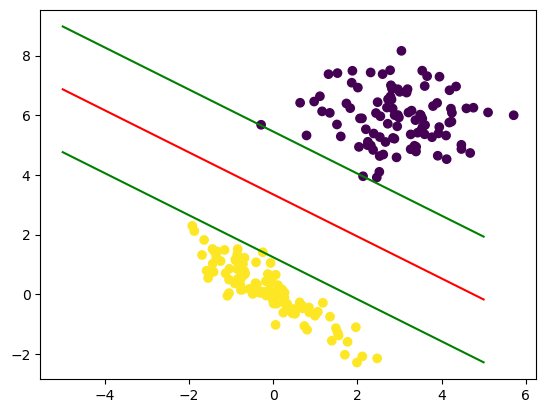

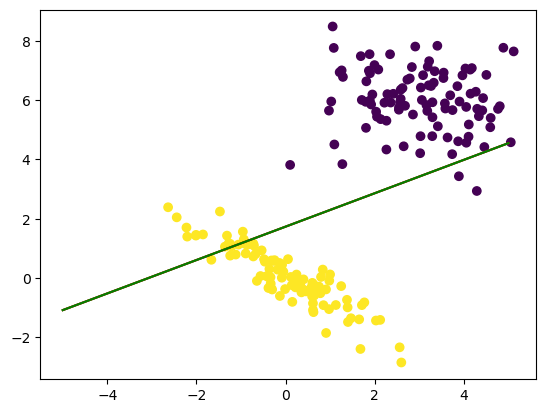

In [15]:
#Let us generate the dataset
X, y = dataset(100)
for K in [0.001,0.1,1,1e3,1e6,1e12]:
    #Let us generate the corresponding matrices
    X, y = dataset(100)
    G, g, A, b, C, d = generation_matrices(X, y, K)

    #Let us compute alpha with the given code
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    #Compute the hyperplane
    w, b =hyper(X, y,alpha,K)
    #Let us plot the result
    x = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:],c=y)
    plt.plot(x, -(w[0]*x + b+1) / w[1], 'g')
    plt.plot(x, -(w[0]*x + b) / w[1], 'r')
    plt.plot(x, -(w[0]*x + b-1) / w[1], 'g')
    plt.show()

Notice that for really small values of $K$ the method does not work. The hyperplane misclassifies a lot of points and the hyperplanes at distance 1 and -1 are not correct. When we increase the value of $K$, the method starts to classify better the points, reaching perfect classification for $K=1$ and $K=10^{3}$. The method has a poor performance when $K$ is a larger value as $K=10^{6}$ or $K=10^{12}$. Actually, for $K=10^{12}$, the method does not work, and sometimes does not converge.

## Experiment 4

To finish, let us test our algorithm with the non-separable case using different values of $K$. Does the value of $K$ influence the obtained solution?

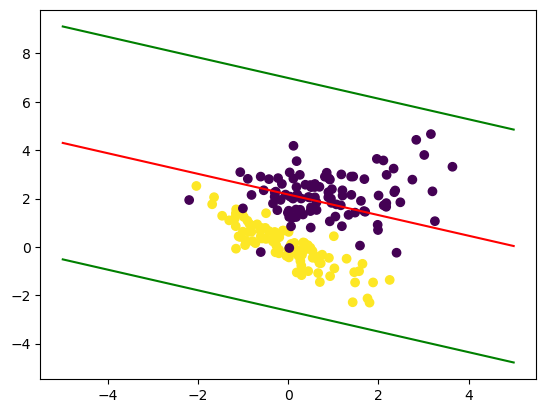

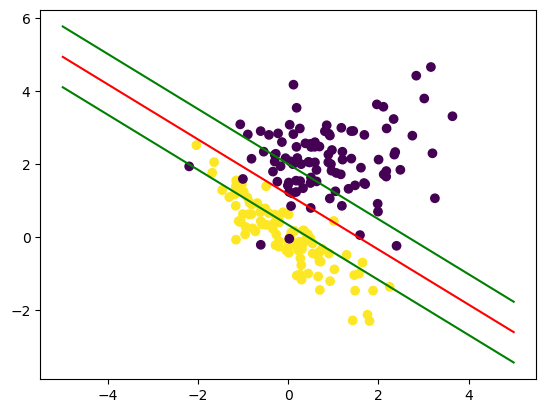

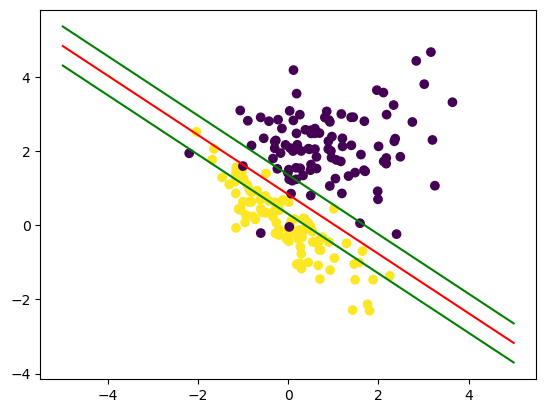

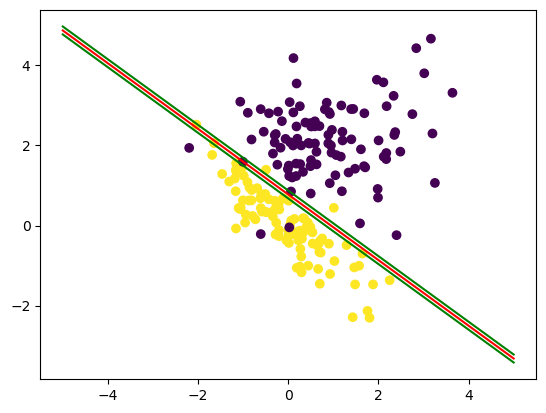

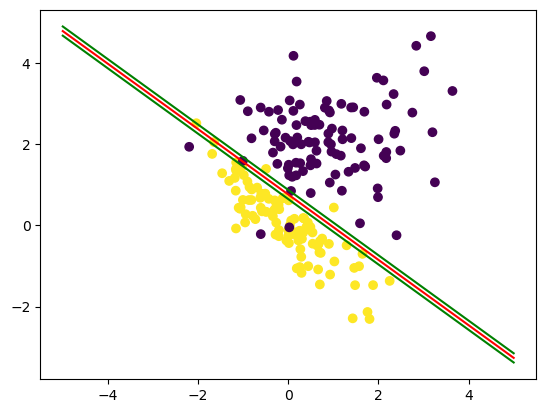

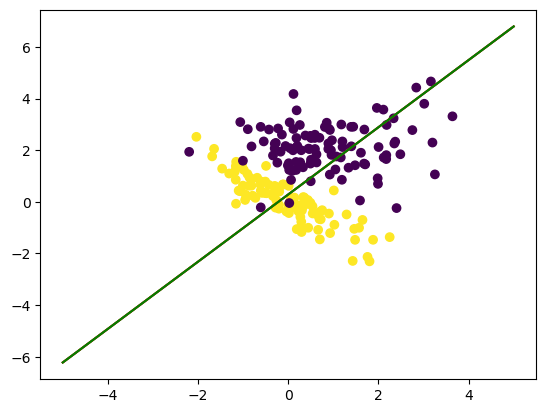

In [16]:
#Let us generate the dataset
X, y = dataset(100,separable = False)
for K in [0.001,0.1,1,1e3,1e6,1e12]:
    #Let us generate the corresponding matrices
    G, g, A, b, C, d = generation_matrices(X, y, K)

    #Let us compute alpha with the given code
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    #Compute the hyperplane
    w, b =hyper(X, y,alpha,K)
    #Let us plot the result
    x = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:],c=y)
    plt.plot(x, -(w[0]*x + b+1) / w[1], 'g')
    plt.plot(x, -(w[0]*x + b) / w[1], 'r')
    plt.plot(x, -(w[0]*x + b-1) / w[1], 'g')
    plt.show()

In this case, notice that, as before, for really small values of $K$, the method does not work. The hyperplane misclassifies a lot of points and the hyperplanes at distance 1 and -1 are not correct. Now, it seems that the larger is the value of $K$, the better we classify. Observe that when we increase the value of $K$, the hyperplane tries to find the better position to avoid misclassification, which will be unavoidable. Nevertheless, as before, for $K=10^{12}$ the method does not work, and sometimes does not converge.